In [1]:
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
matrix_duration = np.load('../matrices/matrice_durate_100.npy')

In [3]:
with open('../coordinates/coord_par_100.json') as f:
    coordinates = json.load(f)

In [4]:
data_json = []
c_nan = 0
for row_index in range(matrix_duration.shape[0]):
    for col_index in range(matrix_duration.shape[1]):
        comb_dict = {}
        comb_dict['from'] = coordinates[row_index][::-1]
        comb_dict['to'] = coordinates[col_index][::-1]
        comb_dict['time'] = matrix_duration[row_index, col_index] / 60
        
        if np.isnan(comb_dict['time']):
            c_nan += 1
            continue

        data_json.append(comb_dict)


# Map creation

In [5]:
# import folium
# import json
# from folium.plugins import MarkerCluster
# from folium import FeatureGroup

# # Esempio di dati: Lista di coordinate con tempi di percorrenza tra coppie di punti
# data = data_json

# # Creazione mappa centrata su Milano
# m = folium.Map(location=[48.86, 2.35], zoom_start=13)

# # Aggiungere punti
# marker_cluster = MarkerCluster(options={'maxClusterRadius': 10}).add_to(m)
# points = set()
# for item in data:
#     points.add(tuple(item['from']))
#     points.add(tuple(item['to']))

# for point in points:
#     folium.Marker(location=point).add_to(marker_cluster)

# # Salvare i dati delle linee in un oggetto JSON per JavaScript
# connections = [{'from': item['from'], 'to': item['to'], 'time': item['time']} for item in data]
# json_data = json.dumps(connections)

# # Aggiungere JavaScript personalizzato per lo slider
# slider_js = f'''
# <script>
#     var connections = {json_data};
#     document.addEventListener("DOMContentLoaded", function() {{
#         window.map = {m.get_name()};
#     }});
#     function updateMap(value) {{
#     if (!window.map) return;
#     window.map.eachLayer(function(layer) {{
#         if (layer instanceof L.Polyline) {{
#             window.map.removeLayer(layer);
#         }}
#     }});
#     connections.forEach(function(conn) {{
#         if (conn.time <= value) {{
#             L.polyline([conn.from, conn.to], {{color: 'blue'}}).addTo(window.map);
#         }}
#     }});
# }}

# function rangeSlide(value) {{
#     document.getElementById('rangeValue').innerHTML = value;
# }}

# function main(value) {{
#     updateMap(value);
#     rangeSlide(value);
# }};
# </script>
# '''

# # Aggiungere il controllo slider nella mappa
# m.get_root().html.add_child(folium.Element(slider_js))

# # Salva la mappa
# m.save("../mappa_interattiva.html")
# print("Mappa salvata come mappa_interattiva.html")

# Analisi spaziali

In [6]:
from shapely.geometry import Point
import geopandas as gpd

In [7]:
df = pd.DataFrame(data_json)

In [8]:
df['from'] = df['from'].apply(lambda coords: Point(coords[1], coords[0]))  # (long, lat)
df['to'] = df['to'].apply(lambda coords: Point(coords[1], coords[0]))  # (long, lat)

In [9]:
parigi_shapefile = gpd.read_file('../shapefiles/paris_arrondissement.geojson')

In [10]:
parigi_shapefile = parigi_shapefile.to_crs(epsg=4326)

In [11]:
# Creiamo un GeoDataFrame dal DataFrame originale per facilitare l'operazione spaziale
gdf_from_points = gpd.GeoDataFrame(df, geometry='from', crs="EPSG:4326")

gdf_from_points = gpd.sjoin(gdf_from_points, parigi_shapefile[['c_ar', 'geometry']], how='left', predicate='within')

gdf_from_points.rename(columns={'c_ar': 'from_arrondissement'}, inplace=True)

gdf_from_points = gdf_from_points.drop(columns='index_right')

In [12]:
gdf_to_points = gpd.GeoDataFrame(df, geometry='to', crs="EPSG:4326")

gdf_to_points = gpd.sjoin(gdf_to_points, parigi_shapefile[['c_ar', 'geometry']], how='left', predicate='within')

gdf_to_points.rename(columns={'c_ar': 'to_arrondissement'}, inplace=True)

gdf_to_points = gdf_to_points.drop(columns='index_right')

In [13]:
# Uniamo i due GeoDataFrame per avere tutte le informazioni in un unico DataFrame
gdf = gdf_from_points.merge(gdf_to_points[['to_arrondissement']], left_index=True, right_index=True)
medie_tempi = (gdf.groupby('to_arrondissement')['time'].mean() + gdf.groupby('from_arrondissement')['time'].mean()) / 2
max_tempi = (gdf.groupby('to_arrondissement')['time'].max() + gdf.groupby('from_arrondissement')['time'].max()) / 2

tempi_df = parigi_shapefile.merge(medie_tempi, left_on='c_ar', right_index=True)

tempi_df = tempi_df.rename(columns={'time': 'mean_time'})

tempi_df = tempi_df.merge(max_tempi, left_on='c_ar', right_index=True)

tempi_df = tempi_df.rename(columns={'time': 'max_time'})

In [14]:
tempi_df.to_file('../static_maps_data/paris_times.geojson', driver='GeoJSON')

# Area analysis

In [15]:
time_steps = np.linspace(0,80,200)

In [16]:
nodes = []
for arrondissement in range(1, 21):
    filtered_gdf = gdf[(gdf['from_arrondissement'] == arrondissement)]
    arr_nodes = []

    for step in time_steps:
        got_nodes = (filtered_gdf['time'] <= step).sum() / len(filtered_gdf)
        arr_nodes.append(got_nodes)

    nodes.append(arr_nodes)

In [17]:
nodes = np.array(nodes)

In [18]:
from matplotlib import colormaps
color_palette = colormaps.get_cmap('tab20')
color_palette = color_palette.resampled(nodes.shape[0])

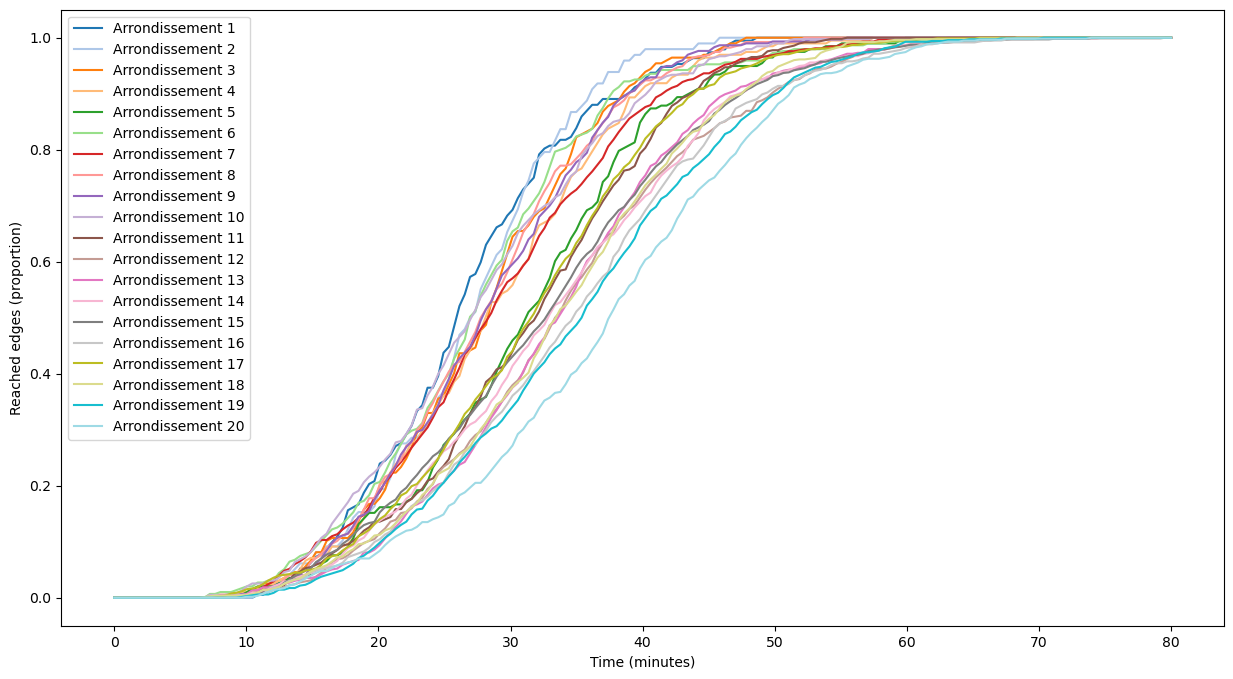

In [19]:
plt.figure(figsize=(15,8))
for arr in range(nodes.shape[0]):
    plt.plot(time_steps, nodes[arr], label=f'Arrondissement {arr+1}', color = color_palette(arr))

plt.xlabel('Time (minutes)')
plt.ylabel('Reached edges (proportion)')
plt.legend()

plt.savefig('../static_maps_data/reached_nodes.png', dpi=300)
plt.show()

In [20]:
def calculate_area(dom_t, acc_city):
    acc_city_b = acc_city[:-1] 
    acc_city_B = acc_city[1:]   
    h = np.diff(dom_t)  

    A = np.sum((acc_city_b + acc_city_B) * h / 2)  

    norm = dom_t[-1]  
    Area = A / norm

    return Area

In [21]:
arrondissements_areas = []
arrondissement_names = []
for arr in range(nodes.shape[0]):
    area = calculate_area(time_steps, nodes[arr])
    arrondissements_areas.append(area)
    arrondissement_names.append(arr+1)
    

In [22]:
df_areas = pd.DataFrame({'Arrondissement': arrondissement_names, 'Area': arrondissements_areas})

In [23]:
df_areas.sort_values('Area', ascending=False).to_csv('../static_maps_data/arrondissements_areas.csv', index=False)

# Single points map creation

In [24]:
point2id = {}
for point in gdf['from'].unique():
    point2id[point] = len(point2id)
id2point = {v: k for k, v in point2id.items()}

In [25]:
gdf['from_id'] = gdf['from'].apply(lambda x: point2id[x])

In [26]:
df_points = gdf.groupby('from_id')['time'].mean().reset_index()

In [27]:
df_points['from'] = df_points['from_id'].apply(lambda x: id2point[x])

In [28]:
df_points = gdf[['from_id', 'from_arrondissement']].merge(df_points, left_on='from_id', right_on='from_id')

In [29]:
gdf_points = gpd.GeoDataFrame(df_points, geometry='from', crs="EPSG:4326")

In [30]:
import geopandas as gpd
import folium
from shapely.geometry import Point
import branca.colormap as cm

In [ ]:
buffer_radius = 300 


projected_gdf = gdf_points.to_crs(epsg=3857)
projected_gdf['buffer'] = projected_gdf.geometry.buffer(buffer_radius)

projected_gdf['buffer'] = projected_gdf['buffer'].simplify(tolerance=5)

buffers = projected_gdf.set_geometry('buffer').to_crs(epsg=4326)

# Crea la mappa centrata su Parigi
m = folium.Map(location=[48.8566, 2.3522], zoom_start=13, tiles='Cartodb positron')

# Crea una scala di colori in base ai valori di 'time'
min_time, max_time = gdf_points['time'].min(), gdf_points['time'].max()
colormap = cm.linear.YlOrRd_09.scale(min_time, max_time)

# Aggiungi i buffer alla mappa con i tooltip attivi sull'hover
for _, row in buffers.iterrows():
    color = colormap(row['time'])
    tooltip_text = f"<div style='font-size:14px;'><strong>Mean time from here:</strong> {round(row['time'], 1)}<br><strong>Arrondissement:</strong> {row['from_arrondissement']}</div>"
    geo_json = folium.GeoJson(
        row['buffer'].__geo_interface__,
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': color,
            'weight': 1,
            'fillOpacity': 0.6,
        }
    )
    folium.Tooltip(tooltip_text, sticky=True).add_to(geo_json)
    geo_json.add_to(m)

# Aggiungi la legenda
colormap.caption = 'Time'
colormap.add_to(m)

# Visualizza la mappa
m

In [32]:
m.save('../paris_buffers.html')